In [1]:
import sys
sys.path.append('../scripts/')
from utility import read_file, create_folder, temp_record_query, temp_record_sdf
# from read_untils import read_file, create_folder, temp_record_query, temp_record_sdf

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10 GiB')
    .config('spark.shuffle.file.buffer', '64k')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

22/09/20 20:20:40 WARN Utils: Your hostname, Runyus-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.3.12 instead (on interface en0)
22/09/20 20:20:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/20 20:20:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
import re
import pandas as pd

In [5]:
PLOT_PATH = '../plots/'

In [6]:
print("================ Merchant ================")
merchants_sdf = read_file(spark, 'tbl_merchants.parquet', truncate=20)

================ Merchant ================
|> Loading File...


|> Loading Finished!
-RECORD 0----------------------------
 name         | Felis Limited        
 tags         | ((furniture, home... 
 merchant_abn | 10023283211          
only showing top 1 row



In [7]:
print("================ Transactions ================")
transactions_sdf = read_file(spark, 'transactions_20210228_20210827_snapshot')

================ Transactions ================
|> Loading File...
|> Loading Finished!
-RECORD 0----------------------------------------------
 user_id        | 18478                                
 merchant_abn   | 62191208634                          
 dollar_value   | 63.255848959735246                   
 order_id       | 949a63c8-29f7-4ab0-ada4-99ac50a88952 
 order_datetime | 2021-08-20                           
only showing top 1 row



### 1. 根据 Transaction 数据可以推测：商家是使用他们的 ABN 作为标识来对应 Transaction 数据


- 由于数量不大，使用 pandas 对与商家的 Tags 数据进行预处理


In [8]:
merchants_sdf.count()

4026

In [9]:
merchants_df_origin = pd.DataFrame(merchants_sdf.collect(), columns=['merchant_name', 'tags', 'merchant_abn']) 
merchants_df = merchants_df_origin.copy()

In [10]:
merchants_df_origin.tags.iloc[0]

'((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))'

- 查看商家和商家 abn 是不是一一对应的 (是一一对应)


In [11]:
# Is there have duplicated merchant abn
merchants_df.loc[merchants_df.duplicated(['merchant_abn'])].size

0

In [12]:
# Is there have duplicated merchants name
merchants_df.loc[merchants_df.duplicated(['merchant_name'])].size

0

### 2. 处理 tags 文本信息


In [13]:
merchants_df = merchants_df_origin.copy()

In [14]:
for i in range(10):
    print(merchants_df.tags.loc[i])

((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))
([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])
([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.40])
([wAtch, clock, and jewelry repair shops], [b], [take rate: 3.29])
([music shops - musical instruments, pianos, and sheet music], [a], [take rate: 6.33])
[(gift, card, novelty, and souvenir shops), (a), (take rate: 6.34)]
[(computers, comPUter peripheral equipment, and softwAre), (b), (take rate: 4.32)]
[[watch, clock, and jewelry repair shops], [c], [take rate: 2.39]]
([computer programming , data processing, and integrated systems design services], [a], [take rate: 5.71])
[(furniture, home furnishings and equipment shopS, and manufacturers, except appliances), (a), (take rate: 6.61)]


In [15]:
# 把tags里的信息，划分成三个column

def tags_reg_func(s):
    s = re.sub(r'\(|\[', '', s[:-2])
    return re.split(r'\), |\], ', s)

merchants_df.tags = merchants_df.tags.apply(lambda x: tags_reg_func(x))

In [16]:
merchants_df['take_rate']  = merchants_df.tags.apply(lambda x: float(re.findall(r"\d+\.?\d*", x[2])[0]) )

In [17]:
merchants_df['type']  = merchants_df.tags.apply(lambda x: x[1] )

In [18]:
# tags信息全小写
merchants_df['tags']  = merchants_df.tags.apply(lambda x: x[0].lower() )

In [19]:
from collections import defaultdict
new_dict = defaultdict(int)

In [20]:
merchants_df.tags = merchants_df.tags.apply(lambda x: re.sub(r'\ +', ' ', x))

In [21]:
merchants_df.to_parquet('../data/curated/merchants_data.parquet')

### PLOT

- Sunburst


In [274]:
merchants_df = pd.read_parquet('../data/curated/merchants_data.parquet')

In [275]:
merchants_tag = merchants_df.drop_duplicates('tags').reset_index(drop=True)

In [276]:
# 缩短标签画图
merchants_df_simplised = merchants_df.copy()
# merchants_df_simplised.tags = merchants_df.tags.apply(lambda x: re.sub(r'[^(a-z)]', '', x.split(' ')[0]) )
merchants_df_simplised.tags = merchants_df.tags.apply(lambda x: x.split(',')[0] )
merchants_df_simplised.merchant_name = merchants_df.merchant_name.apply(lambda x: x.split(' ')[0])

In [277]:
# dict_data = defaultdict()
# groupby_tag = merchants_df_simplised.groupby('tags')
# for head, f in groupby_tag:
#     children = defaultdict()
#     grouped = f.groupby('type')
#     for a, b in grouped:
#         child = list(f.groupby('merchant_name').size().reset_index().rename({'merchant_name': 'name', 0:'value'}, axis=1).T.to_dict().values())
#         children[a] = { 'name':a, 'children': child }
#     dict_data[head] = { 'name':head, 'children': list(children.values()) }


In [278]:
# dict_data = defaultdict()
# groupby_tag = merchants_df_simplised.groupby('type')
# for head, f in groupby_tag:
#     child = list(f.groupby('tags').size().reset_index().rename({'tags': 'name', 0:'value'}, axis=1).T.to_dict().values())
#     dict_data[head] = { 'name':head, 'children': child }

In [279]:
dict_data = defaultdict()
groupby_tag = merchants_df_simplised.groupby('tags')
for head, f in groupby_tag:
    child = list(f.groupby('type').size().reset_index().rename({'type': 'name', 0:'value'}, axis=1).T.to_dict().values())
    dict_data[head] = { 'name':head, 'children': child }

In [280]:
from pyecharts.charts import Sunburst
from pyecharts import options as opts

"""
Gallery 使用 pyecharts 1.2.1
参考地址: https://www.echartsjs.com/examples/editor.html?c=sunburst-simple

目前无法实现的功能:

1、暂无
"""
data = list(dict_data.values())
c = (
    Sunburst(init_opts=opts.InitOpts(width="1000px", height="900px"))
    .add(
        "",
        data_pair=data,
        highlight_policy="ancestor",
        radius=[0, "95%"],
        sort_="null",
        levels=[
            {},
            {
                "r0": "10%",
                "r": "60%",
                "itemStyle": {"borderWidth": 2},
                "label": {
                    # "rotate": 'tangential',
                }
            },
            {"r0": "60%", "r": "70%", "label": {
                "align": "right"
                }
            },
            {
                "r0": "70%",
                "r": "72%",
                "label": {"position": "outside", "padding": 3, "silent": False},
                "itemStyle": {"borderWidth": 3},
            },
        ],
    )
    .set_global_opts(title_opts=opts.TitleOpts(title="Merchants Tags --- Sunburst"))
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}"))
    .render(f'{PLOT_PATH}merchants_sunburst.html')
)


- Scatter


In [138]:
merchants_df = pd.read_parquet('../data/curated/merchants_data.parquet')

In [139]:
merchants_df = merchants_df.sort_values('type', axis=0)

In [140]:
data = [list(merchants_df.columns)] + merchants_df.to_numpy().tolist() 

In [141]:
from pyecharts import options as opts
from pyecharts.charts import Grid, Scatter
from pyecharts.globals import ThemeType

l1_1 = (
    Scatter()
    .add_dataset(
        dimensions=[
            "merchant_name",
            "tags",
            "merchant_abn",
            "take_rate",
            {"name": "type", "type": "ordinal"},
        ],
        source=data
    )
    .add_yaxis(
        series_name="",
        y_axis=[],
        symbol_size=2.5,
        xaxis_index=1,
        yaxis_index=1,
        encode={"x": "type", "y": "take_rate", "tooltip": [0, 1, 2, 3]}, 
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        xaxis_opts=opts.AxisOpts(
            type_="category",
            grid_index=0,
            name="Type",
            boundary_gap=True,
            axislabel_opts=opts.LabelOpts(interval=0),
        ),
        yaxis_opts=opts.AxisOpts(
            type_="value", 
            name="Rate",
        ),
        title_opts=opts.TitleOpts(title="Encode and Matrix"),
    )
    
)




l1_2 = (
    Scatter()
    .add_dataset()
    .add_yaxis(
        series_name="",
        y_axis=[],
        symbol_size=2.5,
        xaxis_index=1,
        yaxis_index=1,
        encode={"x": "take_rate", "y": "tags", "tooltip": [0, 1, 2, 3]}, 
        label_opts=opts.LabelOpts(is_show=False),
    )
    .set_global_opts(
        yaxis_opts=opts.AxisOpts(
            type_="category",
            grid_index=1,
            name="Type",
            boundary_gap=True,
            axislabel_opts=opts.LabelOpts(rotate=10, interval=0),
        ),
        xaxis_opts=opts.AxisOpts(
            type_="value", 
            name="Rate",
        ),
    )
)


grid = (
    # theme: CHALK, ESSOS
    Grid(init_opts=opts.InitOpts(width="1960px", height="960px", theme=ThemeType.CHALK))
    .add(
        chart=l1_1,
        grid_opts=opts.GridOpts(pos_left="80%"),
        grid_index=0,
    )
    .add(
        chart=l1_2,
        grid_opts=opts.GridOpts(pos_left="28%", pos_right="25%"),
        grid_index=1,
    )
    .render(f'{PLOT_PATH}merchants_scatter.html')
)

- tag sum

In [282]:
dict_data = defaultdict()
groupby_tags = merchants_df.groupby('type')
for h, d in groupby_tags:
    dict_data[h] = d.groupby('tags')['merchant_abn'].count()

In [283]:
from pyecharts import options as opts
from pyecharts.charts import Bar, Grid, Line, Pie

keys = list(dict_data.keys())

bar = (
    Bar()
    .add_xaxis(list(dict_data[keys[0]].index))
    .add_yaxis(keys[4], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[3], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[2], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[1], dict_data[keys[1]].to_list(), stack="stack1")
    .add_yaxis(keys[0], dict_data[keys[0]].to_list(), stack="stack1")
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    .set_global_opts(title_opts=opts.TitleOpts(title="Bar-Stacked Diagram by Types of Merchants", pos_top="2%", pos_left="30%"),
        xaxis_opts=opts.AxisOpts(
            type_="category",
            boundary_gap=True,
            axislabel_opts=opts.LabelOpts(rotate=-45),
        ),
        legend_opts=opts.LegendOpts(is_show=False),
    )
    
)


pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(keys, merchants_df.groupby('type')['merchant_abn'].count().to_list())],
        radius=["20%", "55%"],
        center=["80%", "40%"],
        rosetype="area",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="Pie-Total Types of Merchant Score Count", pos_top="8%", pos_left="65%"),
        legend_opts=opts.LegendOpts(pos_left="70%", pos_top="75%"),
    )
)

grid = (
    Grid(init_opts=opts.InitOpts(width="1960px", height="960px", theme=ThemeType.CHALK))
    .add(bar, grid_opts=opts.GridOpts(pos_right="40%", pos_bottom="40%"))
    .add(pie, grid_opts=opts.GridOpts(pos_left="90%"))
    .render(f'{PLOT_PATH}merchants_general.html'))

- violin plot

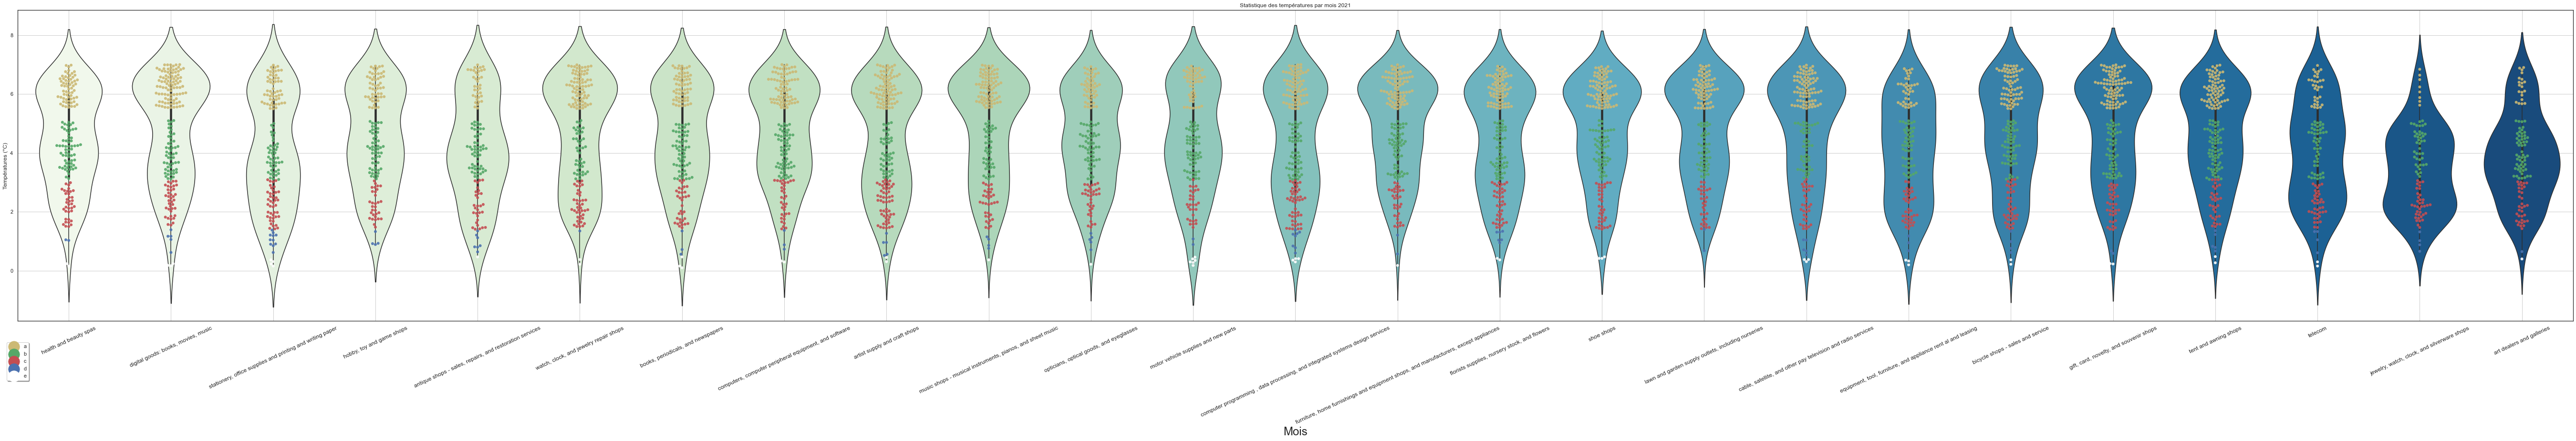

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(96,12))
fontsize=18

# 设置figure窗体的颜色
plt.rcParams['figure.facecolor'] = 'black'

# 设置axes绘图区的颜色
plt.rcParams['axes.facecolor'] = 'black'

plt.rcParams['font.size']=24


plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)

plt.xticks( rotation=25, fontsize=12)
sns.set(color_codes=True)

sns.set_style("white")
sns.violinplot(x = merchants_df['tags'],
               y = merchants_df['take_rate'],
               ax=ax,
               palette="GnBu",
               inner = "box",
               )
# sns.stripplot(x = merchants_df['tags'],
#                y = merchants_df['take_rate'], color ='w', size = 4, alpha = 0.9, jitter=True)

sns.swarmplot(x = merchants_df['tags'],
               y = merchants_df['take_rate'], 
               hue = merchants_df['type'],
               palette = ['y','g','r','b','w'],
               size = 6, alpha = 0.9)

ax.set_title('Statistique des températures par mois 2021')
ax.set_xlabel('Mois', fontsize=24)
ax.set_ylabel('Températures (°C)')
ax.grid(True)
ax.legend(loc='lower center',bbox_to_anchor=(0, -0.2),markerscale=3,shadow=True)


plt.show()  

### Bag of Words

In [136]:
# ! pip3.7 install unidecode
# ! pip3.7 install contractions

In [137]:
import unidecode
import contractions
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from collections import Counter

In [69]:
# clean string data

# Convert accented characters  return:string
def accented_char(text):
    text = unidecode.unidecode(text)
    return text

# expand_contractions return:string
def expand_contrac(text):
    text = contractions.fix(text)
    return text

# remove num and symbol return: string
def replace_num_and_symbol(text):
    text = text.lower()
    result = re.sub('[\W_]+', ' ', text)
    new_string = re.sub(r'([\d]+)([a-z]+)', '', result)
    new_string = re.sub(r'([a-z]+)([\d]+)', '', new_string)
    new_string = re.sub(r'[\d]+', '', new_string)
    return new_string

# remove stopwords 
def remove_stop_words(text):
    text_tokens = word_tokenize(text)
    all_stopwords = stopwords.words('english')
    token_without_sw = [word for word in text_tokens if not word in all_stopwords]
    # filter_sentence = ''.join(token_without_sw)
    return token_without_sw

# Lemmatisation
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
    
def word_lemmatizer(data_list):
    # tokens = word_tokenize(text)
    tagged_sent = pos_tag(data_list)
    lem_list = WordNetLemmatizer()
    word_list = []
    for tag in tagged_sent:
        wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
        word_list.append(lem_list.lemmatize(tag[0], pos=wordnet_pos))
    return word_list

def clean_string(text):
    # using all functions above to clean string
    remove_accent_char = accented_char(text)
    remove_extraction = expand_contrac(remove_accent_char)
    remove_num_and_symbol_string = replace_num_and_symbol(remove_extraction)
    filter_sentence = remove_stop_words(remove_num_and_symbol_string)
    word_list = word_lemmatizer(filter_sentence)
    clean_string = ' '.join(word_list)
    return clean_string

In [73]:
text_info = [x[0] for x in merchants_df[['merchant_name']].values]
word_list = []
for item in text_info:
    text_tokens = word_tokenize(clean_string(item))
    for word in text_tokens:
        word_list.append(word)
word_counter = Counter(word_list)

In [88]:
new_counter = sorted(word_counter.items(), key=lambda d: d[1],reverse=True)

[('ltd', 312), ('llp', 301), ('llc', 296), ('inc', 295), ('corp', 295), ('corporation', 288), ('foundation', 288), ('incorporate', 278), ('industry', 275), ('associate', 270), ('institute', 265), ('pc', 264), ('limit', 263), ('sed', 176), ('company', 164), ('mauris', 140), ('nunc', 137), ('non', 133), ('eu', 128), ('ac', 125), ('et', 122), ('ut', 115), ('consulting', 115), ('nec', 108), ('nulla', 98), ('enim', 98), ('aliquam', 97), ('donec', 95), ('eget', 93), ('arcu', 93), ('ipsum', 92), ('magna', 89), ('vitae', 89), ('egestas', 88), ('elit', 86), ('sit', 85), ('dolor', 83), ('lorem', 83), ('vel', 82), ('aliquet', 81), ('orci', 79), ('sem', 77), ('est', 71), ('amet', 70), ('dictum', 69), ('lacus', 69), ('risus', 68), ('velit', 67), ('pede', 66), ('id', 66), ('odio', 64), ('mi', 64), ('ante', 62), ('neque', 61), ('tellus', 61), ('duo', 60), ('auctor', 60), ('libero', 60), ('quis', 60), ('phasellus', 60), ('erat', 59), ('cras', 58), ('tincidunt', 57), ('suspendisse', 57), ('malesuada', 

In [90]:
import pyecharts.options as opts
from pyecharts.charts import WordCloud
"""
Gallery 使用 pyecharts 1.1.0
参考地址: https://gallery.echartsjs.com/editor.html?c=xS1jMxuOVm

目前无法实现的功能:

1、暂无
"""
(
    WordCloud()
    .add(series_name="merchants_name_word", data_pair=new_counter, word_size_range=[6, 66])
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="Analysis_of_merchants_name_words", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
        ),
        tooltip_opts=opts.TooltipOpts(is_show=True),
    )
    .render(f"{PLOT_PATH}basic_wordcloud.html")
)


'/Users/runyuyang/Downloads/2022S2/generic-buy-now-pay-later-project-group-24/plots/basic_wordcloud.html'